##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Regression: predict house pricing

<table class="tfo-notebook-buttons" align="left">
  <td>Modified from </>
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Kaggle House prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) Dataset and builds a model to predict the house prices from 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. you can read more about the dataset by following the link above.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [3]:
# Use seaborn for pairplot
!pip install seaborn

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## The Auto MPG dataset

The dataset is available from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).



### Get the data
First download the dataset.

In [5]:
dataset_path = keras.utils.get_file("train.data", "https://raw.githubusercontent.com/gakuba/house_pricing/master/train.data")
dataset_path

466944/460676 [==============================] - 0s 0us/step


'/Users/gakuba/.keras/datasets/train.data'

Import it using pandas. since the aim of this tutorial is to show various techniques when building a regression model with neural networks using tensorflow, We've decided to choose a few features that are easy to understand and from which we believe the impact to the price is almost obvious

In [6]:
column_names = ['MSSubClass','MSZoning','LotArea','LotShape',
                'LandContour', 'LotConfig', 'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','YearRemodAdd',
               'RoofStyle','MasVnrArea','TotalBsmtSF','Heating','HeatingQC','1stFlrSF','2ndFlrSF','GrLivArea','BedroomAbvGr','KitchenAbvGr','PoolArea','SalePrice']
raw_dataset = pd.read_csv(dataset_path, 
                      na_values = "NA", comment='\t',
                      sep=",",usecols=column_names, skipinitialspace=False)

dataset = raw_dataset.copy()
dataset.tail()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,TotalBsmtSF,Heating,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,PoolArea,SalePrice
1455,60,RL,7917,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,...,953,GasA,Ex,953,694,1647,3,1,0,175000
1456,20,RL,13175,Reg,Lvl,Inside,Gtl,NWAmes,Norm,Norm,...,1542,GasA,TA,2073,0,2073,3,1,0,210000
1457,70,RL,9042,Reg,Lvl,Inside,Gtl,Crawfor,Norm,Norm,...,1152,GasA,Ex,1188,1152,2340,4,1,0,266500
1458,20,RL,9717,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,...,1078,GasA,Gd,1078,0,1078,2,1,0,142125
1459,20,RL,9937,Reg,Lvl,Inside,Gtl,Edwards,Norm,Norm,...,1256,GasA,Gd,1256,0,1256,3,1,0,147500


### Clean the data

The dataset contains a few unknown values.

In [7]:
dataset.isna().sum()

MSSubClass      0
MSZoning        0
LotArea         0
LotShape        0
LandContour     0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
RoofStyle       0
MasVnrArea      8
TotalBsmtSF     0
Heating         0
HeatingQC       0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
BedroomAbvGr    0
KitchenAbvGr    0
PoolArea        0
SalePrice       0
dtype: int64

MasVnrArea has 8 entries with unknow values. To keep this initial tutorial simple drop those rows. In practice you may not want to lose your data in which case you can build a simple model to predict the unknown values. depending on observation sometimes you can replace the missing values with the mean or median of all the values within the same column

In [8]:
dataset = dataset.dropna()

later on this tutorial we will use onehot encoding to transform categorical variables into numbers either 0 or 1. this is known to create a lot of troubles when a particular value is present in the training set and not in the test set and vice versa which causes the number of features generated in both sets to be different. to avoid this issue, let's drop all rows that have unique categorical value that is not present in any other row. 

In [9]:
print('MSSubClass',(dataset['MSSubClass'].value_counts()==1).any())
print('MSZoning',(dataset['MSZoning'].value_counts()==1).any())
print('LotShape',(dataset['LotShape'].value_counts()==1).any())
print('LandContour',(dataset['LandContour'].value_counts()==1).any())
print('LotConfig',(dataset['LotConfig'].value_counts()==1).any())
print('LandSlope',(dataset['LandSlope'].value_counts()==1).any())
print('Neighborhood',(dataset['Neighborhood'].value_counts()==1).any())
print('Condition1',(dataset['Condition1'].value_counts()==1).any())
print('Condition2',(dataset['Condition2'].value_counts()==1).any())
print('BldgType',(dataset['BldgType'].value_counts()==1).any())
print('HouseStyle',(dataset['HouseStyle'].value_counts()==1).any())
print('RoofStyle',(dataset['RoofStyle'].value_counts()==1).any())
print('Heating',(dataset['Heating'].value_counts()==1).any())
print('HeatingQC',(dataset['HeatingQC'].value_counts()==1).any())

MSSubClass False
MSZoning False
LotShape False
LandContour False
LotConfig False
LandSlope False
Neighborhood False
Condition1 False
Condition2 True
BldgType False
HouseStyle False
RoofStyle False
Heating True
HeatingQC True


According to the findings above, `"HeatingQC","Condition2","Heating"` have a value that shows up only once in the dataset, we need to delete such values since the it is guaranteed to create a std of zero either in the training set or the test set

In [10]:
print(dataset['HeatingQC'].value_counts())
dataset = dataset[dataset['HeatingQC'] != 'Po']

Ex    734
TA    427
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


In [11]:
print(dataset['Condition2'].value_counts())
dataset = dataset[(dataset['Condition2'] != 'RRAn') & (dataset['Condition2'] != 'RRAe') & (dataset['Condition2'] != 'PosA')]

Norm      1436
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAe         1
RRAn         1
Name: Condition2, dtype: int64


In [12]:
print(dataset['Heating'].value_counts())
dataset = dataset[dataset['Heating'] != 'Floor']

GasA     1416
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


Sometimes deleting this values ends by rendering some new rows to be unique on a different categorical column. we need to double check if this is the case.

In [13]:
print('MSSubClass',(dataset['MSSubClass'].value_counts()==1).any())
print('MSZoning',(dataset['MSZoning'].value_counts()==1).any())
print('LotShape',(dataset['LotShape'].value_counts()==1).any())
print('LandContour',(dataset['LandContour'].value_counts()==1).any())
print('LotConfig',(dataset['LotConfig'].value_counts()==1).any())
print('LandSlope',(dataset['LandSlope'].value_counts()==1).any())
print('Neighborhood',(dataset['Neighborhood'].value_counts()==1).any())
print('Condition1',(dataset['Condition1'].value_counts()==1).any())
print('Condition2',(dataset['Condition2'].value_counts()==1).any())
print('BldgType',(dataset['BldgType'].value_counts()==1).any())
print('HouseStyle',(dataset['HouseStyle'].value_counts()==1).any())
print('RoofStyle',(dataset['RoofStyle'].value_counts()==1).any())
print('Heating',(dataset['Heating'].value_counts()==1).any())
print('HeatingQC',(dataset['HeatingQC'].value_counts()==1).any())

MSSubClass False
MSZoning False
LotShape False
LandContour False
LotConfig False
LandSlope False
Neighborhood False
Condition1 False
Condition2 False
BldgType False
HouseStyle False
RoofStyle True
Heating False
HeatingQC False


Ooops the RoofStyle has now a unique value. let's find what it is and delete it

In [14]:
dataset['RoofStyle'].value_counts()

Gable      1131
Hip         284
Flat         13
Gambrel      11
Mansard       7
Shed          1
Name: RoofStyle, dtype: int64

In [15]:
print(dataset['RoofStyle'].value_counts())
dataset = dataset[dataset['RoofStyle'] != 'Shed']

Gable      1131
Hip         284
Flat         13
Gambrel      11
Mansard       7
Shed          1
Name: RoofStyle, dtype: int64


You can double check again if no unique values are left but I have already done that to keep this notebook short.

Let's now convert  `"columns"` that are categorical to one-hot encoded values:

In [16]:
def onehot(df,column_name):
  # receives a column name are return a dataframe where the column name has been converted to onehot encoding
  categorical_values = df[column_name].unique()
  data_to_encode = df.pop(column_name)
  
  for cat_value in categorical_values:
    col_name = column_name+str(cat_value)
    df[col_name] = (data_to_encode == cat_value)* 1.0
  #return df
  

In [17]:
onehot(dataset,'MSSubClass')
onehot(dataset,'MSZoning')
onehot(dataset,'LotShape')
onehot(dataset,'LandContour')
onehot(dataset,'LotConfig')
onehot(dataset,'LandSlope')
onehot(dataset,'Neighborhood')
onehot(dataset,'Condition1')
onehot(dataset,'Condition2')
onehot(dataset,'BldgType')
onehot(dataset,'HouseStyle')
onehot(dataset,'RoofStyle')
onehot(dataset,'Heating')
onehot(dataset,'HeatingQC')

In [18]:
dataset.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,RoofStyleFlat,HeatingGasA,HeatingGasW,HeatingGrav,HeatingWall,HeatingOthW,HeatingQCEx,HeatingQCGd,HeatingQCTA,HeatingQCFa
0,8450,7,5,2003,2003,196.0,856,856,854,1710,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,9600,6,8,1976,1976,0.0,1262,1262,0,1262,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11250,7,5,2001,2002,162.0,920,920,866,1786,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9550,7,5,1915,1970,0.0,756,961,756,1717,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,14260,8,5,2000,2000,350.0,1145,1145,1053,2198,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
dataset.shape

(1446, 116)

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [20]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


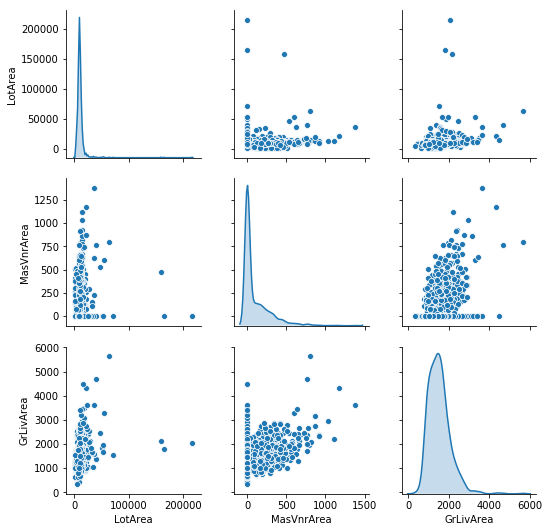

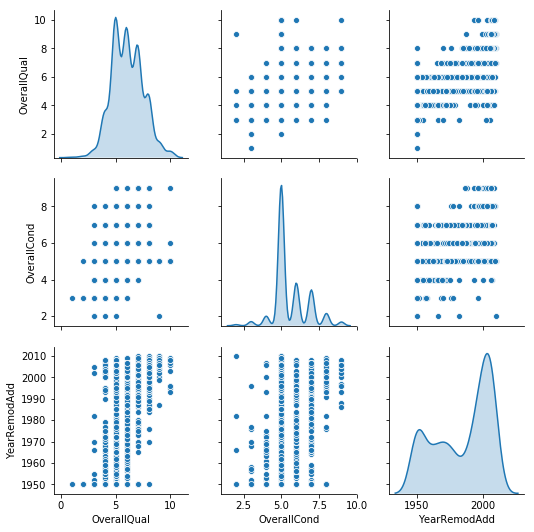

In [21]:
sns.pairplot(train_dataset[["LotArea", "MasVnrArea", "GrLivArea"]], diag_kind="kde")
sns.pairplot(train_dataset[["OverallQual","OverallCond" , "YearRemodAdd"]], diag_kind="kde")

We can see that some features are correlated. to have a full picture, let's draw a pairwise map of correlation for all non categorical values.

**Plot the correlation plot of a random sample of 200 features (`train_dataset[non_categ_variables].sample(n=200))` with `seaborn`.**

- Seaborn: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

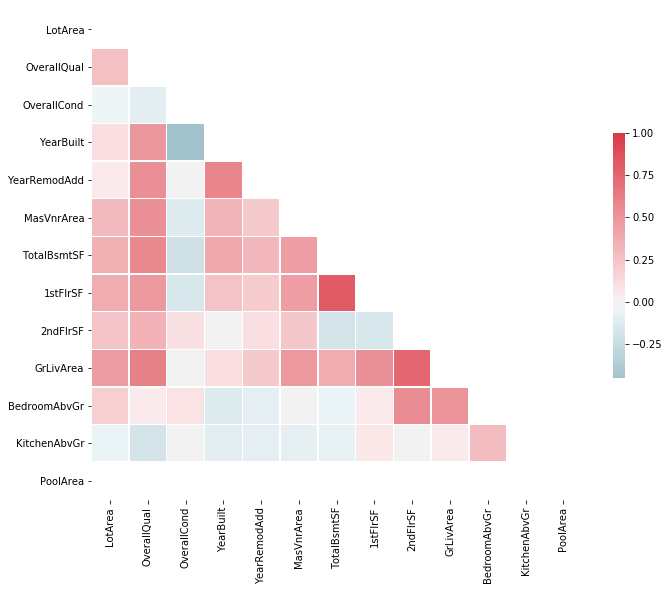

In [22]:
# seaborn
non_categ_variables = ['LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BedroomAbvGr','KitchenAbvGr',
                       'PoolArea']
sampled =  train_dataset[non_categ_variables].sample(n=200)
corr = sampled.corr()  # compute correlation matrix
mask = np.zeros_like(corr, dtype=np.bool)  # make mask
mask[np.triu_indices_from(mask)] = True  # mask the upper triangle

fig, ax = plt.subplots(figsize=(11, 9))  # create a figure and a subplot
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # custom color map
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    linewidth=0.5,
    cbar_kws={'shrink': 0.5}
);

Looking at the above table we can see a few strong correlations. However since we run random samples, we observed after repetitively running the cell, that a few of them are consistent. particularly there is a consistent strong positive correlation between **GrLivArea**(the size of Living area) and **2ndFlrSF**(the size of the second floor). we also see a high positive correlation between **1stFlrSF**(the size of 1st floor) and **TotalBsmtSF**(total basement surface). what if we drop**1stFlrSF** and **2ndFlrSF**? note that you don't always have to drop one of the correlated features. only when you are sure that the values of one feature is linearly dependent to the other, then you can delete either of them since the value of the deleted feature was obtained from a combination of the maintained one. there are a lot statistical consideration that I did not mention here but you get the big picture.

In [23]:
train_dataset = train_dataset.drop(['1stFlrSF','2ndFlrSF'],axis=1)
test_dataset = test_dataset.drop(['1stFlrSF','2ndFlrSF'],axis=1)

Also look at the overall statistics:

In [24]:
train_stats = train_dataset.describe()
train_stats.pop("SalePrice")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
LotArea,1157.0,10580.938634,10406.555540,1300.0,7596.0,9525.0,11600.0,215245.0
OverallQual,1157.0,6.092481,1.393604,1.0,5.0,6.0,7.0,10.0
OverallCond,1157.0,5.579084,1.108326,2.0,5.0,5.0,6.0,9.0
YearBuilt,1157.0,1971.057908,30.290992,1872.0,1953.0,1972.0,2000.0,2010.0
YearRemodAdd,1157.0,1984.528090,20.807911,1950.0,1965.0,1994.0,2004.0,2010.0
MasVnrArea,1157.0,103.337943,176.203486,0.0,0.0,0.0,166.0,1378.0
TotalBsmtSF,1157.0,1056.707001,445.687102,0.0,793.0,991.0,1288.0,6110.0
GrLivArea,1157.0,1520.535004,535.173435,334.0,1134.0,1466.0,1786.0,5642.0
BedroomAbvGr,1157.0,2.878997,0.809256,0.0,2.0,3.0,3.0,8.0
KitchenAbvGr,1157.0,1.045808,0.217273,0.0,1.0,1.0,1.0,3.0


One noticeable to see in the stats above is the difference in the scale of the values. later in this tutorial we will introduce a technique called normalisation used to fix this issue by putting all the features on the same scale between -1 and 1 and centered on 0.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:
train_labels = train_dataset.pop('SalePrice')
test_labels = test_dataset.pop('SalePrice')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [26]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [27]:
normed_train_data.shape

(1157, 113)

Sometimes if you have not been careful in the first steps, you may end up having features with a mean and a standard deviation equal to zero which will cause issues in the calculation of the normalised value. to test if nothing as such happened, check if the normalized dataset has any NaN values.

In [28]:
normed_train_data.isna().values.any()

False

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [29]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [30]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7296      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [32]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.18740621],
       [-0.37517387],
       [ 0.44027066],
       [-0.13944644],
       [-0.05899712],
       [ 0.1826899 ],
       [-0.03595413],
       [-0.02398375],
       [ 0.01398684],
       [-2.5624623 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [33]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

Visualize the model's training progress using the stats stored in the `history` object.

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,3.335265e+08,10503.631836,333526464.0,1.893144e+09,23414.792969,1.893144e+09,995
996,3.334866e+08,10488.290039,333486560.0,1.893136e+09,23418.982422,1.893135e+09,996
997,3.335728e+08,10476.440430,333572864.0,1.894983e+09,23419.917969,1.894983e+09,997
998,3.330735e+08,10474.593750,333073504.0,1.897619e+09,23411.398438,1.897619e+09,998
999,3.331989e+08,10465.067383,333198944.0,1.891481e+09,23421.921875,1.891481e+09,999


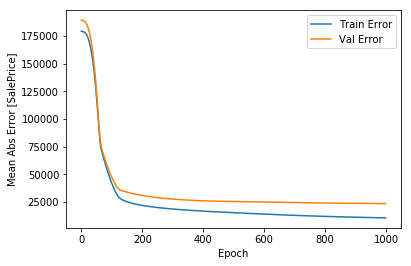

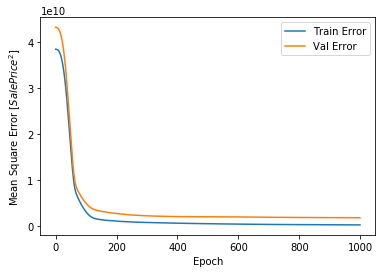

In [35]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [SalePrice]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$SalePrice^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....

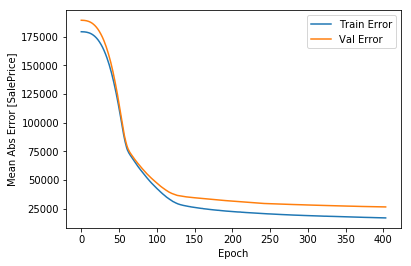

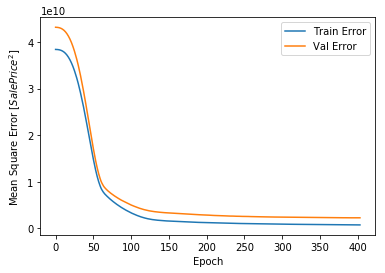

In [36]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 30K $. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} SalePrice".format(mae))

Testing set Mean Abs Error: 22823.59 SalePrice


### Make predictions

Finally, predict House price values using data in the testing set:

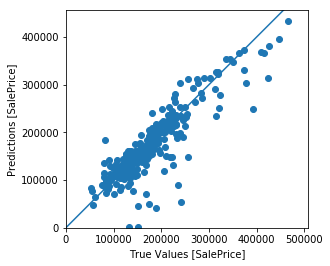

In [38]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SalePrice]')
plt.ylabel('Predictions [SalePrice]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-1000000, 1000000], [-1000000, 1000000])


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

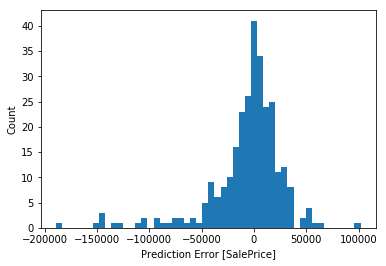

In [39]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [SalePrice]")
_ = plt.ylabel("Count")
#_ = plt.plot([-10000, 10000], [-10000, 10000])

It's not quite gaussian, but we might expect that because the number of samples is very small. Also you can see that the distribution is centered around zero(definitely not zero if the scale is changed, but I am happy with that). which is a very good indication that our model isn't far from ground truth in most cases.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.